# Experiment 2

*Hypothesis*: for the same per-agent probing budget, allocating prefixes to agents based on an adaptive approach
(with the possibility of a prefix to be probed from any number from 0 to n agents)
will allow more to be discovered than allocating prefixes to agents randomly (with each prefix being probed from precisely one agent).

In [3]:
from pathlib import Path


exp_dir = Path("./resources/data/measurements/exp2/")

with (exp_dir / "zeph.txt").open("r") as fd:
    zeph_uuids = [uuid.strip() for uuid in fd.readlines()]
with (exp_dir / "exploration.txt").open("r") as fd:
    exploration_uuids = [uuid.strip() for uuid in fd.readlines()]
with (exp_dir / "constrained_exploration.txt").open("r") as fd:
    constrained_exploration_uuids = [uuid.strip() for uuid in fd.readlines()]
with (exp_dir / "constrained_zeph.txt").open("r") as fd:
    constrained_zeph_uuids = [uuid.strip() for uuid in fd.readlines()]

In [4]:
# Get Iris API / database credentials
from config.config import * 
from zeph.drivers import create_auth_header, get_database_url

headers = create_auth_header(iris_url, iris_username, iris_password)

# Get ChProxy database URL
database_url = get_database_url(iris_url, headers) + "&no_cache=1"

## Links

In [5]:
from diamond_miner.queries import GetLinks
from zeph.drivers import get_previous_measurement_agents

def sanitize_uuid(uuid):
    return str(uuid).replace("-", "_")


def get_links(measurement_uuid):
    agents_uuid = get_previous_measurement_agents(iris_url, measurement_uuid, headers)
    
    distinct_links = set()
    for agent_uuid in agents_uuid:
        measurement_id = sanitize_uuid(measurement_uuid) + "__" + sanitize_uuid(agent_uuid)
        for link in GetLinks().execute_iter(database_url, measurement_id):
            distinct_links.add((link["near_addr"], link["far_addr"])) 
    return distinct_links

In [6]:
zeph_n_links = []
for uuid in zeph_uuids:
    zeph_n_links.append(len(get_links(uuid)))
exploration_n_links = []
for uuid in exploration_uuids:
    exploration_n_links.append(len(get_links(uuid)))
constrained_exploration_n_links = []
for uuid in constrained_exploration_uuids:
    constrained_exploration_n_links.append(len(get_links(uuid)))
constrained_zeph_n_links = []
for uuid in constrained_zeph_uuids:
    constrained_zeph_n_links.append(len(get_links(uuid)))

print(zeph_n_links)
print(exploration_n_links)
print(constrained_exploration_n_links)
print(constrained_zeph_n_links)

[1312411, 1643748, 1776420, 1862660, 1906901, 1932468, 1953851, 1940732, 1934102, 1975131]
[1309661, 1278711, 1301691, 1282089, 1285787, 1273213, 1250004, 1257523, 1271269, 1306999]
[1397572, 1386996, 1376577, 1375248, 1354416, 1357908, 1346312, 1344087, 1341361, 1382974]
[1459864, 1594706, 1630338, 1658091, 1647807, 1654716, 1630776, 1610196, 1647522, 1649087]


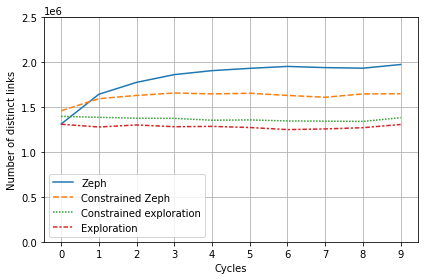

In [7]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import seaborn as sns

data = pd.DataFrame({
    "Zeph": zeph_n_links,
    "Constrained Zeph": constrained_zeph_n_links,
    "Constrained exploration": constrained_exploration_n_links,
    "Exploration": exploration_n_links,
})

ax = sns.lineplot(data=data)

ax.set(xlabel="Cycles", ylabel="Number of distinct links")
ax.set(ylim=(0, 2_500_000))

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.grid()

plt.tight_layout()
plt.savefig("./resources/figures/exp2_links.pdf")
plt.show()

## Nodes

In [8]:
from diamond_miner.queries import GetNodes

def get_nodes(measurement_uuid):
    agents_uuid = get_previous_measurement_agents(iris_url, measurement_uuid, headers)
    
    distinct_nodes = set()
    for agent_uuid in agents_uuid:
        measurement_id = sanitize_uuid(measurement_uuid) + "__" + sanitize_uuid(agent_uuid)
        for node in GetNodes().execute_iter(database_url, measurement_id):
            distinct_nodes.add(node["reply_src_addr"]) 
    return distinct_nodes

In [9]:

zeph_n_nodes = []
for uuid in zeph_uuids:
    zeph_n_nodes.append(len(get_nodes(uuid.strip())))
exploration_n_nodes = []
for uuid in exploration_uuids:
    exploration_n_nodes.append(len(get_nodes(uuid.strip())))
constrained_exploration_n_nodes = []
for uuid in constrained_exploration_uuids:
    constrained_exploration_n_nodes.append(len(get_nodes(uuid.strip())))
constrained_zeph_n_nodes = []
for uuid in constrained_zeph_uuids:
    constrained_zeph_n_nodes.append(len(get_nodes(uuid.strip())))

print(zeph_n_nodes)
print(exploration_n_nodes)
print(constrained_exploration_n_nodes)
print(constrained_zeph_n_nodes)

[673757, 795182, 844494, 869081, 879816, 891045, 898327, 900541, 897402, 902202]
[675544, 668039, 678249, 677574, 672336, 672963, 664330, 669018, 672298, 681980]
[762047, 761299, 760511, 760283, 752976, 756630, 753301, 753104, 752812, 760171]
[776749, 827574, 841899, 848152, 850241, 852302, 848357, 845145, 849889, 849600]


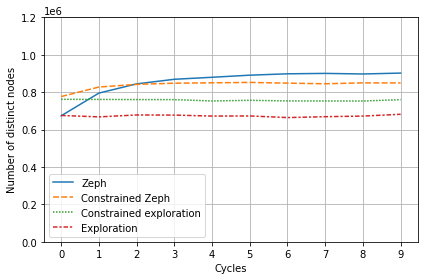

In [10]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import seaborn as sns

data = pd.DataFrame({
    "Zeph": zeph_n_nodes,
    "Constrained Zeph": constrained_zeph_n_nodes,  
    "Constrained exploration": constrained_exploration_n_nodes,
    "Exploration": exploration_n_nodes,
})

ax = sns.lineplot(data=data)

ax.set(xlabel="Cycles", ylabel="Number of distinct nodes")
ax.set(ylim=(0, 1_200_000))

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.grid()

plt.tight_layout()
plt.savefig("./resources/figures/exp2_nodes.pdf")
plt.show()

## Probes

In [11]:
import requests 

def get_statistic(measurement_uuid, statistic):    
    data = requests.get(iris_url + f"/measurements/{measurement_uuid}", headers=headers)

    packets_sent = 0
    for agent in data.json()["agents"]:
        for probing_round in agent["probing_statistics"].values():
            packets_sent += probing_round.get(statistic, 0)
    return packets_sent

In [12]:
zeph_n_probes = []
for uuid in zeph_uuids:
    zeph_n_probes.append(get_statistic(uuid, "packets_sent"))
exploration_n_probes = []
for uuid in exploration_uuids:
    exploration_n_probes.append(get_statistic(uuid, "packets_sent"))
constrained_exploration_n_probes = []
for uuid in constrained_exploration_uuids:
    constrained_exploration_n_probes.append(get_statistic(uuid, "packets_sent"))
constrained_zeph_n_probes = []
for uuid in constrained_zeph_uuids:
    constrained_zeph_n_probes.append(get_statistic(uuid, "packets_sent"))

print(zeph_n_probes)
print(exploration_n_probes)
print(constrained_exploration_n_probes)
print(constrained_zeph_n_probes)

[297035375, 297035375, 297035375, 297035375, 297035375, 297035375, 297035375, 297035375, 297035375, 297035375]
[297035375, 297035375, 297035375, 297035375, 297035375, 297035375, 297035375, 297035375, 297035375, 297035375]
[297035375, 297035375, 297035375, 297035375, 297035375, 297035375, 297035375, 297035375, 297035375, 297035375]
[297035375, 297035375, 297035375, 297035375, 297035375, 297035375, 297035375, 297035375, 297035375, 297035375]


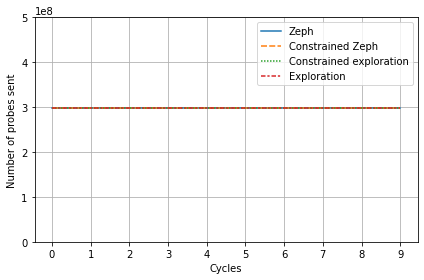

In [13]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import seaborn as sns

data = pd.DataFrame({
    "Zeph": zeph_n_probes,
    "Constrained Zeph": constrained_zeph_n_probes, 
    "Constrained exploration": constrained_exploration_n_probes,
    "Exploration": exploration_n_probes,
})

ax = sns.lineplot(data=data)

ax.set(xlabel="Cycles", ylabel="Number of probes sent")
ax.set(ylim=(0, 500_000_000))

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.grid()

plt.tight_layout()
plt.savefig("./resources/figures/exp2_probes.pdf")
plt.show()